In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout

!pip install fastparquet
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.0 MB/s eta 0:00:00


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Sep 10 19:08:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Read the processed dataset.
semg_df = pd.read_parquet('/content/drive/MyDrive/sEMG-HAR/semg_extracted_more_features', engine='fastparquet')

semg_df

,subject_id,activity,trial_index,semg_1_td_mean,semg_1_td_rms,semg_1_td_sd,semg_1_td_var,semg_1_td_iemg,semg_1_td_zcr,semg_1_td_ssc,...,semg_3_tfd_hjorth,semg_3_tfd_arcoeffs,semg_4_tfd_stft,semg_4_tfd_mfcc,semg_4_tfd_hjorth,semg_4_tfd_arcoeffs,semg_5_tfd_stft,semg_5_tfd_mfcc,semg_5_tfd_hjorth,semg_5_tfd_arcoeffs
0,5,20,3,0.007527,32.994613,32.994613,1088.644456,465531.475412,2317,4180,...,"[7.708834652764494, 7.709010892616439, 7.70954...","[7.708834652764494, 7.709010892616439, 7.70954...","[1.0064211140819452, 1.0092077942869477, 1.017...","[1.0064211140819452, 1.0092077942869477, 1.017...","[1.0064211140819452, 1.0092077942869477, 1.017...","[1.0064211140819452, 1.0092077942869477, 1.017...","[310.56733342211373, 310.5691632707391, 310.57...","[310.56733342211373, 310.5691632707391, 310.57...","[310.56733342211373, 310.5691632707391, 310.57...","[310.56733342211373, 310.5691632707391, 310.57..."
1,10,20,4,-0.006587,44.476383,44.476383,1978.148624,429311.110991,2114,4012,...,"[153.78781638860954, 153.78786196755996, 153.7...","[153.78781638860954, 153.78786196755996, 153.7...","[613.5029555407747, 613.5050181882475, 613.511...","[613.5029555407747, 613.5050181882475, 613.511...","[613.5029555407747, 613.5050181882475, 613.511...","[613.5029555407747, 613.5050181882475, 613.511...","[45.36440806490623, 45.36743359968911, 45.3765...","[45.36440806490623, 45.36743359968911, 45.3765...","[45.36440806490623, 45.36743359968911, 45.3765...","[45.36440806490623, 45.36743359968911, 45.3765..."
2,6,20,10,0.001336,8.073858,8.073858,65.187177,124953.964457,3182,5333,...,"[322.1779260799889, 322.1789827395294, 322.182...","[322.1779260799889, 322.1789827395294, 322.182...","[468.2028466841613, 468.2122601584829, 468.240...","[468.2028466841613, 468.2122601584829, 468.240...","[468.2028466841613, 468.2122601584829, 468.240...","[468.2028466841613, 468.2122601584829, 468.240...","[2.1613993955644375, 2.161413970956996, 2.1614...","[2.1613993955644375, 2.161413970956996, 2.1614...","[2.1613993955644375, 2.161413970956996, 2.1614...","[2.1613993955644375, 2.161413970956996, 2.1614..."
3,1,20,9,0.002790,21.087234,21.087233,444.671412,324534.585663,2833,4778,...,"[1.348005314617751, 1.3480321269880162, 1.3481...","[1.348005314617751, 1.3480321269880162, 1.3481...","[52.352982899279134, 52.35321899582158, 52.353...","[52.352982899279134, 52.35321899582158, 52.353...","[52.352982899279134, 52.35321899582158, 52.353...","[52.352982899279134, 52.35321899582158, 52.353...","[6.648577666104643, 6.64867443223733, 6.648965...","[6.648577666104643, 6.64867443223733, 6.648965...","[6.648577666104643, 6.64867443223733, 6.648965...","[6.648577666104643, 6.64867443223733, 6.648965..."
4,8,20,10,0.000866,41.998197,41.998197,1763.848562,481195.451785,3024,5038,...,"[23.12080078554669, 23.121273762321056, 23.122...","[23.12080078554669, 23.121273762321056, 23.122...","[30.107865417110588, 30.107955036601975, 30.10...","[30.107865417110588, 30.107955036601975, 30.10...","[30.107865417110588, 30.107955036601975, 30.10...","[30.107865417110588, 30.107955036601975, 30.10...","[0.9820094907973669, 0.9820031528972324, 0.981...","[0.9820094907973669, 0.9820031528972324, 0.981...","[0.9820094907973669, 0.9820031528972324, 0.981...","[0.9820094907973669, 0.9820031528972324, 0.981..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,6,11,6,0.000350,9.513134,9.513134,90.499723,130480.665329,2364,4103,...,"[24.869527038763188, 24.86968772605987, 24.870...","[24.869527038763188, 24.86968772605987, 24.870...","[3.5199747069944465, 3.5198081203170544, 3.519...","[3.5199747069944465, 3.5198081203170544, 3.519...","[3.5199747069944465, 3.5198081203170544, 3.519...","[3.5199747069944465, 3.5198081203170544, 3.519...","[2.8651581711222676, 2.8651377616485254, 2.865...","[2.8651581711222676, 2.8651377616485254, 2.865...","[2.8651581711222676, 2.8651377616485254, 2.865...","[2.8651581711222676, 2.8651377616485254, 2.865..."
1172,5,11,9,

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

NO_WINDOWS = 10

non_scalar_features = ['activity', 'semg_1_fd_fft', 'semg_2_fd_fft', 'semg_3_fd_fft', 'semg_4_fd_fft', 'semg_5_fd_fft',
                      'semg_1_fd_psd', 'semg_2_fd_psd', 'semg_3_fd_psd', 'semg_4_fd_psd', 'semg_5_fd_psd',
                      'semg_1_tfd_stft', 'semg_2_tfd_stft', 'semg_3_tfd_stft', 'semg_4_tfd_stft', 'semg_5_tfd_stft',
                      'semg_1_tfd_mfcc', 'semg_2_tfd_mfcc', 'semg_3_tfd_mfcc', 'semg_4_tfd_mfcc', 'semg_5_tfd_mfcc',
                      'semg_1_tfd_hjorth', 'semg_2_tfd_hjorth', 'semg_3_tfd_hjorth', 'semg_4_tfd_hjorth', 'semg_5_tfd_hjorth',
                      'semg_1_tfd_arcoeffs', 'semg_2_tfd_arcoeffs', 'semg_3_tfd_arcoeffs', 'semg_4_tfd_arcoeffs', 'semg_5_tfd_arcoeffs']

scalar_X = semg_df.drop(columns=non_scalar_features)

non_scalar_features = ['semg_1_fd_fft', 'semg_2_fd_fft', 'semg_3_fd_fft', 'semg_4_fd_fft', 'semg_5_fd_fft',
                      'semg_1_fd_psd', 'semg_2_fd_psd', 'semg_3_fd_psd', 'semg_4_fd_psd', 'semg_5_fd_psd',
                      'semg_1_tfd_stft', 'semg_2_tfd_stft', 'semg_3_tfd_stft', 'semg_4_tfd_stft', 'semg_5_tfd_stft',
                      'semg_1_tfd_mfcc', 'semg_2_tfd_mfcc', 'semg_3_tfd_mfcc', 'semg_4_tfd_mfcc', 'semg_5_tfd_mfcc',
                      'semg_1_tfd_hjorth', 'semg_2_tfd_hjorth', 'semg_3_tfd_hjorth', 'semg_4_tfd_hjorth', 'semg_5_tfd_hjorth',
                      'semg_1_tfd_arcoeffs', 'semg_2_tfd_arcoeffs', 'semg_3_tfd_arcoeffs', 'semg_4_tfd_arcoeffs', 'semg_5_tfd_arcoeffs']

non_scalar_X = semg_df[non_scalar_features]
y = semg_df['activity'].astype('int')

# One-hot encoding for the labels
y = to_categorical(y-1, num_classes=21)

# Extract the 'activity' column from the one-hot encoded labels
activity_labels = np.argmax(y, axis=1)

# Split data into training and validation sets while preserving class proportions
scalar_X_train, scalar_X_val, non_scalar_X_train, non_scalar_X_val, y_train, y_val = train_test_split(
    scalar_X, non_scalar_X, y, test_size=0.2, random_state=42, stratify=activity_labels
)


# Standardize the scalar data
scaler = StandardScaler()
scalar_X_train_standardized = scaler.fit_transform(scalar_X_train)
scalar_X_val_standardized = scaler.transform(scalar_X_val)

non_scalar_train_X_list = non_scalar_X_train.values
non_scalar_val_X_list = non_scalar_X_val.values


# Apply the scaler to the list-type columns
for col in non_scalar_X_train.columns:
    non_scalar_X_train.loc[:, col] = non_scalar_X_train[col].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten().tolist())

# Apply the scaler to the list-type columns
for col in non_scalar_X_val.columns:
    non_scalar_X_val.loc[:, col] = non_scalar_X_val[col].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten().tolist())

In [5]:
max_sequence_length = max(len(col) for sequence in non_scalar_train_X_list for col in sequence)
print("max_sequence_length: ", max_sequence_length)

non_scalar_train_X_list = non_scalar_X_train.values
non_scalar_val_X_list = non_scalar_X_val.values

# Pad the sequence data to the maximum length
X_sequence_train_padded = []
for sequence in non_scalar_train_X_list:
    sequence_padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    X_sequence_train_padded.append(sequence_padded)
X_sequence_train_padded = np.array(X_sequence_train_padded)

X_sequence_val_padded = []
for sequence in non_scalar_val_X_list:
    sequence_padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    X_sequence_val_padded.append(sequence_padded)
X_sequence_val_padded = np.array(X_sequence_val_padded)



max_sequence_length:  20000


Initial Basic Hybrid Model

In [17]:
from keras.regularizers import l1_l2
from keras.layers import Bidirectional
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dropout, Dense, Flatten
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Define the number of classes
num_classes = y_train.shape[1]

# Regularization hyperparameters
l1_lambda = 0.001  # L1 regularization hyperparameter
l2_lambda = 0.001  # L2 regularization hyperparameter

# Reshape it to have a single timestep for each input sample
input_scalar = Input(shape=(scalar_X_train_standardized.shape[1], 1))  # Add an extra dimension

# Create Bidirectional GRU for scalar features
bi_gru_layer = Bidirectional(GRU(64, activation='relu', kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), return_sequences=True))(input_scalar)

# Transpose the sequence data to match the expected shape
X_sequence_train_padded_transposed = np.transpose(X_sequence_train_padded, (0, 2, 1))
X_sequence_val_padded_transposed = np.transpose(X_sequence_val_padded, (0, 2, 1))

# Create RNN for sequence data (LSTM or GRU) with regularization
input_sequence = Input(shape=(max_sequence_length, non_scalar_X_train.shape[1]))
rnn_layer = Bidirectional(GRU(64, kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda)))(input_sequence)

# After bi_gru_layer and rnn_layer, add dropouts
bi_gru_layer_dropout = Dropout(0.5)(bi_gru_layer)
rnn_layer_dropout = Dropout(0.5)(rnn_layer)

# Add Flatten layer to reduce dimensionality of bi_gru_layer_dropout
bi_gru_layer_flatten = Flatten()(bi_gru_layer_dropout)

# Merge the outputs of Bidirectional GRU and RNN with dropout
merged_output = concatenate([bi_gru_layer_flatten, rnn_layer_dropout])

# Add classification layer
output_layer = Dense(num_classes, activation='softmax')(merged_output)

# Create the model
model = Model(inputs=[input_scalar, input_sequence], outputs=output_layer)

# Define Early Stopping with patience for val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
batch_size = 128

# Train the model with early stopping
history = model.fit([scalar_X_train_standardized, X_sequence_train_padded_transposed], y_train,
          validation_data=([scalar_X_val_standardized, X_sequence_val_padded_transposed], y_val),
          epochs=epochs, batch_size=batch_size,
          callbacks=[early_stopping])


Epoch 1/100
8/8 [==============================] - 20s 2s/step - loss: 3.2851 - accuracy: 0.2649 - val_loss: 2.9422 - val_accuracy: 0.4619
Epoch 2/100
8/8 [==============================] - 12s 2s/step - loss: 2.1655 - accuracy: 0.6032 - val_loss: 2.3623 - val_accuracy: 0.5763
Epoch 3/100
8/8 [==============================] - 13s 2s/step - loss: 1.6821 - accuracy: 0.7362 - val_loss: 2.2757 - val_accuracy: 0.5932
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 1.3939 - accuracy: 0.7809 - val_loss: 1.8905 - val_accuracy: 0.6398
Epoch 5/100
8/8 [==============================] - 12s 2s/step - loss: 1.1866 - accuracy: 0.8287 - val_loss: 1.7161 - val_accuracy: 0.7203
Epoch 6/100
8/8 [==============================] - 12s 2s/step - loss: 0.9719 - accuracy: 0.8840 - val_loss: 1.6143 - val_accuracy: 0.7119
Epoch 7/100
8/8 [==============================] - 12s 2s/step - loss: 0.8511 - accuracy: 0.8851 - val_loss: 1.6253 - val_accuracy: 0.7500
Epoch 8/100
8/8 [==========

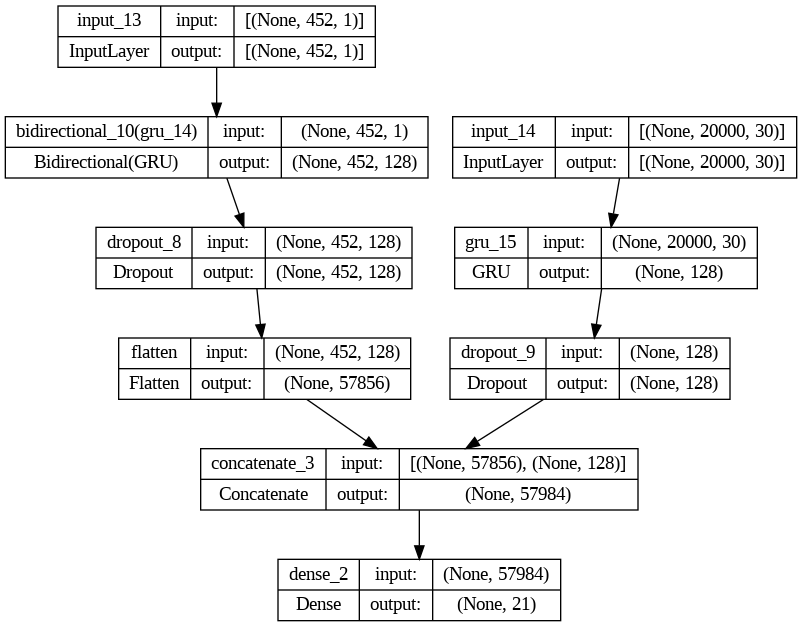

8/8 [==============================] - 3s 273ms/step
Validation Set Metrics:
Accuracy: 0.6822
Precision: 0.7364
Recall: 0.6822
F1-Score: 0.6673


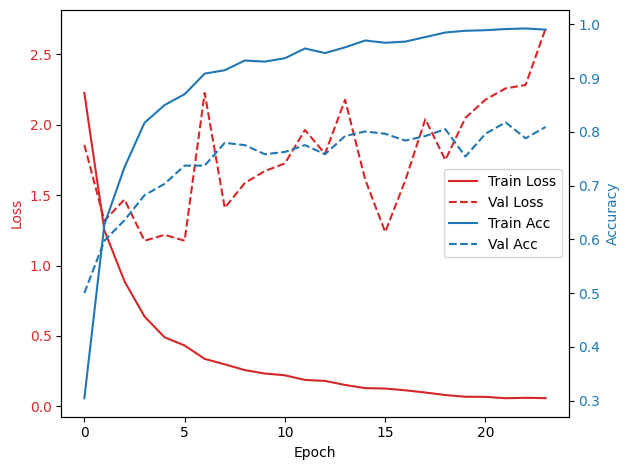

8/8 [==============================] - 2s 274ms/step


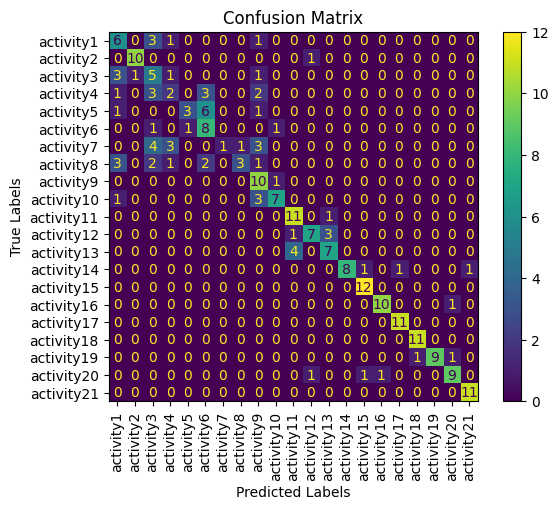

y_val (236, 21)


In [15]:
from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the validation set
y_val_pred = model.predict([scalar_X_val_standardized, X_sequence_val_padded_transposed])
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict([scalar_X_val_standardized, X_sequence_val_padded_transposed])

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_val.shape)


Applying PCA to the Scalar features.

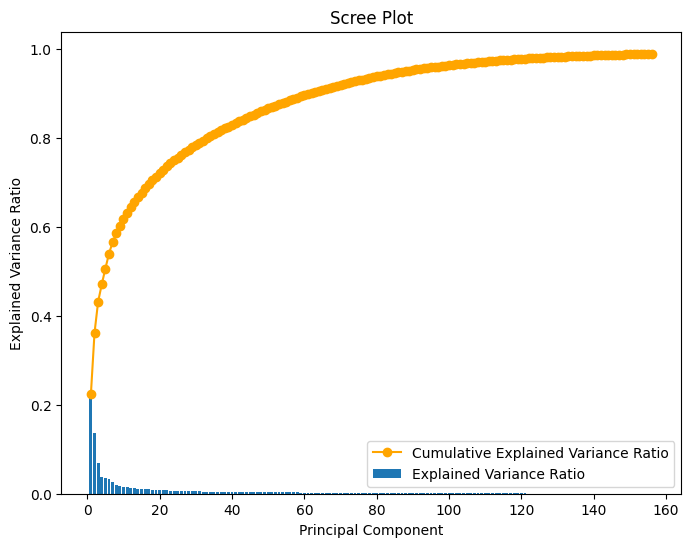

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.99)  # Preserve 99% of the total variance
scalar_X_train_pca = pca.fit_transform(scalar_X_train_standardized)
scalar_X_val_pca = pca.transform(scalar_X_val_standardized)

# Plot the scree plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center', label='Explained Variance Ratio')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='orange', label='Cumulative Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()


In [8]:
from keras.regularizers import l1_l2
from keras.layers import Bidirectional
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dropout, Dense, Flatten
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Define the number of classes
num_classes = y_train.shape[1]

# Define L1/L2 regularizer
l1_l2_reg = l1_l2(l1=0.002, l2=0.002)

# Reshape it to have a single timestep for each input sample
input_scalar = Input(shape=(scalar_X_train_pca.shape[1], 1))  # Add an extra dimension

# Create Bidirectional GRU for scalar features
bi_gru_layer = Bidirectional(GRU(64, activation='relu',
                                recurrent_regularizer=l1_l2_reg,
                                kernel_regularizer=l1_l2_reg,
                                bias_regularizer=l1_l2_reg,
                                return_sequences=True
                            ))(input_scalar)

# Transpose the sequence data to match the expected shape
X_sequence_train_padded_transposed = np.transpose(X_sequence_train_padded, (0, 2, 1))
X_sequence_val_padded_transposed = np.transpose(X_sequence_val_padded, (0, 2, 1))

# Create RNN for sequence data (LSTM or GRU) with regularization
input_sequence = Input(shape=(max_sequence_length, non_scalar_X_train.shape[1]))
rnn_layer = Bidirectional(GRU(64, kernel_regularizer=l1_l2(l1=0.002, l2=0.002)))(input_sequence)

# After bi_gru_layer and rnn_layer, add dropouts
bi_gru_layer_dropout = Dropout(0.6)(bi_gru_layer)
rnn_layer_dropout = Dropout(0.6)(rnn_layer)

# Add Flatten layer to reduce dimensionality of bi_gru_layer_dropout
bi_gru_layer_flatten = Flatten()(bi_gru_layer_dropout)

# Merge the outputs of Bidirectional GRU and RNN with dropout
merged_output = concatenate([bi_gru_layer_flatten, rnn_layer_dropout])

# Add classification layer
output_layer = Dense(num_classes, activation='softmax')(merged_output)

# Create the model
model = Model(inputs=[input_scalar, input_sequence], outputs=output_layer)

# Define Early Stopping with patience for val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
batch_size = 128

# Train the model with early stopping
history = model.fit([scalar_X_train_pca, X_sequence_train_padded_transposed], y_train,
          validation_data=([scalar_X_val_pca, X_sequence_val_padded_transposed], y_val),
          epochs=epochs, batch_size=batch_size,
          callbacks=[early_stopping])


Epoch 1/100
8/8 [==============================] - 24s 2s/step - loss: 7.9590 - accuracy: 0.1426 - val_loss: 7.3510 - val_accuracy: 0.3517
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 6.8432 - accuracy: 0.3723 - val_loss: 6.3376 - val_accuracy: 0.5466
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 5.8038 - accuracy: 0.6340 - val_loss: 5.5524 - val_accuracy: 0.5636
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 4.8887 - accuracy: 0.7191 - val_loss: 4.8356 - val_accuracy: 0.6441
Epoch 5/100
8/8 [==============================] - 10s 1s/step - loss: 4.1356 - accuracy: 0.7511 - val_loss: 4.2542 - val_accuracy: 0.6229
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 3.5057 - accuracy: 0.7755 - val_loss: 3.9207 - val_accuracy: 0.6525
Epoch 7/100
8/8 [==============================] - 10s 1s/step - loss: 2.9732 - accuracy: 0.8202 - val_loss: 3.5753 - val_accuracy: 0.6949
Epoch 8/100
8/8 [==========

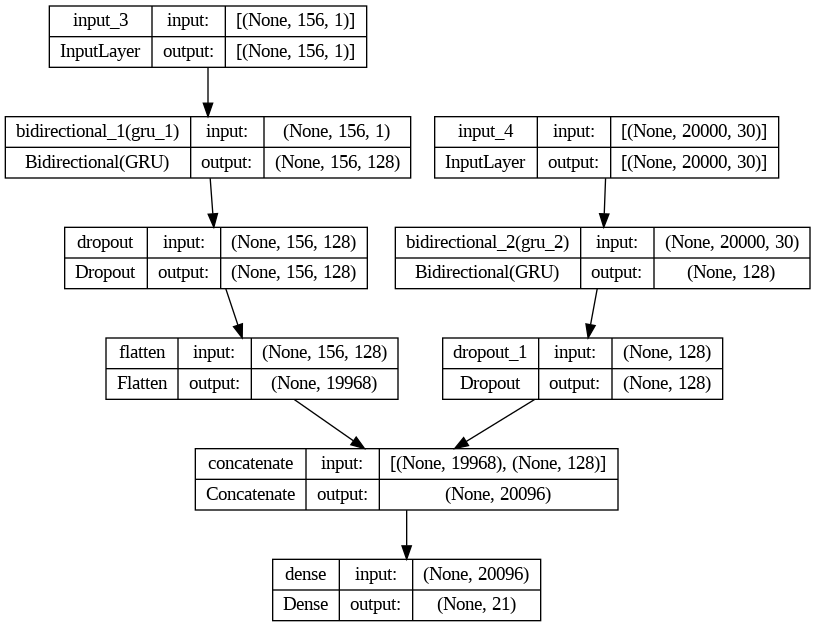

8/8 [==============================] - 4s 435ms/step
Validation Set Metrics:
Accuracy: 0.7331
Precision: 0.7693
Recall: 0.7331
F1-Score: 0.7290


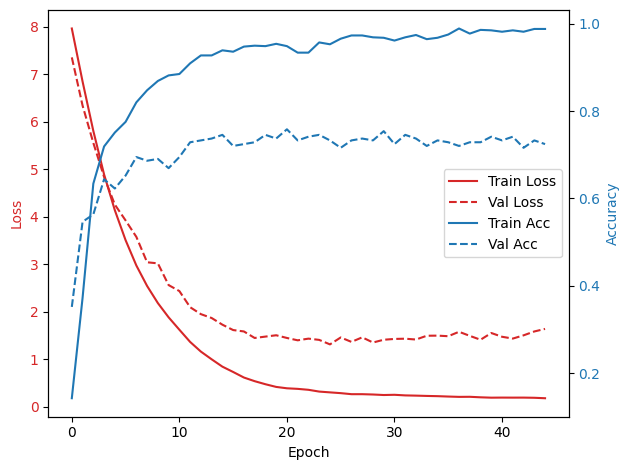

8/8 [==============================] - 4s 436ms/step


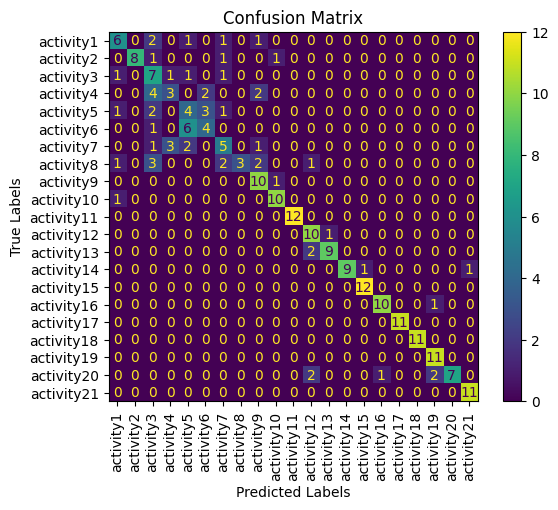

y_val (236, 21)


In [9]:
from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the validation set
y_val_pred = model.predict([scalar_X_val_pca, X_sequence_val_padded_transposed])
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict([scalar_X_val_pca, X_sequence_val_padded_transposed])

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_val.shape)
